In [1]:
using Pkg
Pkg.activate("../")
#Pkg.instantiate()

  Activating project at `~/Documents/UCL/3x2_analytical`


In [2]:
using LinearAlgebra
using ForwardDiff
using Plots
using LimberJack
using CSV
using YAML
using NPZ
using DataFrames
using PythonCall
using SparseArrays
using Statistics
using Interpolations
sacc = pyimport("sacc");

# Judith's Chain

In [3]:
#using DelimitedFiles
#chain = readdlm("/home/jaimerzp/Documents/UCL/3x2_analytical/data/CosmoDC2/cosmodc2_3x2pt_fourier_lcdm.txt");

In [4]:
#chain_vals = chain[200:end, :]
#param_names = chain[1, :];

#post = chain_vals[:, 32]
#index_of_min = argmax(post)
#row_with_min = chain_vals[index_of_min, :]
#Wm = row_with_min[1]+row_with_min[2]
#Wb = row_with_min[2]
#h0 = row_with_min[5]
#ns = row_with_min[3]
#s8 = row_with_min[29]
#best_params = [Wm, Wb, h0, s8, ns]
#print(best_params)

#nuisances = Dict(
#    "lens_0_b" => row_with_min[13],
#    "lens_1_b" => row_with_min[14],
#    "lens_2_b" => row_with_min[15],
#    "lens_3_b" => row_with_min[16],
#    "lens_4_b" => row_with_min[17],
#    "source_0_m" => row_with_min[8],
#    "source_1_m" => row_with_min[9],
#    "source_2_m" => row_with_min[10],
#    "source_3_m" => row_with_min[11],
#    "source_4_m" => row_with_min[12])

In [5]:
function nz_itp(q, nq, z)
    dq = mean(q[2:end] - q[1:end-1])
    q_range = q[1]:dq:q[end]
    nz_int = cubic_spline_interpolation(q_range, nq;
        extrapolation_bc=Line())
    return nz_int(z)
end

nz_itp (generic function with 1 method)

In [6]:
function make_Cmod(m, data_cov, model; mode="AD")
    n_cls = size(data_cov)[1]
    if mode == "AD"
        println("Using automatic differentiation to compute T")
        T = ForwardDiff.jacobian(model, zeros(m))
    elseif mode == "FD"
        println("Using finite differences to compute T")
        d = 0.05
        T = zeros(n_cls, m)
        for i in 1:m
            e = zeros(m)
            e[i] = d
            T[:, i] = (model(e) .- model(-e)) ./ (2*d)
        end
    end
    Cmod = Symmetric(data_cov + T * T')
    return Cmod
end

make_Cmod (generic function with 1 method)

In [7]:
#dz_err_wlwl = [0.017, 0.017, 0.013, 0.015]
#dz_err_gcgc = [0.007, 0.007, 0.006, 0.01, 0.01]
#dz_err_3x2 = [dz_err_wlwl; dz_err_gcgc]

#dz_cov_wlwl = diagm(dz_err_wlwl.^2)
#dz_cov_gcgc = diagm(dz_err_gcgc.^2)
#dz_cov_3x2 = diagm(dz_err_3x2.^2);

## WLWL

In [8]:

method = "bpz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/wlwl.yml"
nz_path = string("../data/CosmoDC2/image_nzs_", method, "_priors/")
gp_path = string("../data/CosmoDC2/image_gp_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

gp_source_0 = npzread(string(gp_path, "gp_source_0.npz"))
gp_source_1 = npzread(string(gp_path, "gp_source_1.npz"))
gp_source_2 = npzread(string(gp_path, "gp_source_2.npz"))
gp_source_3 = npzread(string(gp_path, "gp_source_3.npz"))
gp_source_4 = npzread(string(gp_path, "gp_source_4.npz"))

gp_zs_source_0 = gp_source_0["z"]
gp_zs_source_1 = gp_source_1["z"]
gp_zs_source_2 = gp_source_2["z"]
gp_zs_source_3 = gp_source_3["z"]
gp_zs_source_4 = gp_source_4["z"]

gp_mean_source_0 = gp_source_0["mean"]
gp_mean_source_1 = gp_source_1["mean"]
gp_mean_source_2 = gp_source_2["mean"]
gp_mean_source_3 = gp_source_3["mean"]
gp_mean_source_4 = gp_source_4["mean"]

gp_chol_source_0 = gp_source_0["chol"]
gp_chol_source_1 = gp_source_1["chol"]
gp_chol_source_2 = gp_source_2["chol"]
gp_chol_source_3 = gp_source_3["chol"]
gp_chol_source_4 = gp_source_4["chol"]

gp_W_source_0 = gp_source_0["W"]
gp_W_source_1 = gp_source_1["W"]
gp_W_source_2 = gp_source_2["W"]
gp_W_source_3 = gp_source_3["W"]
gp_W_source_4 = gp_source_4["W"]

gp_mean_source = [
    gp_mean_source_0; 
    gp_mean_source_1;
    gp_mean_source_2;
    gp_mean_source_3;
    gp_mean_source_4
    ]

meta_wlwl, files_wlwl = make_data(sacc_file, yaml_file;
                        nz_source_0=nz_source_0,
                        nz_source_1=nz_source_1,
                        nz_source_2=nz_source_2,
                        nz_source_3=nz_source_3,
                        nz_source_4=nz_source_4)

meta_wlwl.types = [    
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_source_4


5-element Vector{String}:
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

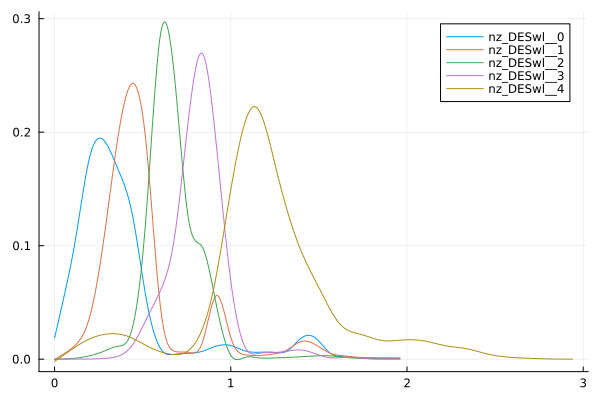

In [9]:
plot(files_wlwl["nz_source_0"][1], files_wlwl["nz_source_0"][2], label="nz_DESwl__0")
plot!(files_wlwl["nz_source_1"][1], files_wlwl["nz_source_1"][2], label="nz_DESwl__1")
plot!(files_wlwl["nz_source_2"][1], files_wlwl["nz_source_2"][2], label="nz_DESwl__2")
plot!(files_wlwl["nz_source_3"][1], files_wlwl["nz_source_3"][2], label="nz_DESwl__3")
plot!(files_wlwl["nz_source_4"][1], files_wlwl["nz_source_4"][2], label="nz_DESwl__4")

In [10]:
function model_wlwl(
    alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_wlwl, files=files_wlwl)

    alphas_source_0 = alphas[1:10]
    alphas_source_1 = alphas[11:20]
    alphas_source_2 = alphas[21:30]
    alphas_source_3 = alphas[31:40]
    alphas_source_4 = alphas[41:50]

    nz_source_0 = gp_W_source_0 * gp_chol_source_0 * alphas_source_0
    nz_source_0 += gp_mean_source_0
    nz_source_1 = gp_W_source_1 * gp_chol_source_1 * alphas_source_1
    nz_source_1 += gp_mean_source_1
    nz_source_2 = gp_W_source_2 * gp_chol_source_2 * alphas_source_2
    nz_source_2 += gp_mean_source_2
    nz_source_3 = gp_W_source_3 * gp_chol_source_3 * alphas_source_3
    nz_source_3 += gp_mean_source_3
    nz_source_4 = gp_W_source_4 * gp_chol_source_4 * alphas_source_4
    nz_source_4 += gp_mean_source_4

    nuisances = Dict(
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_5_b"    => lens_5_b,
        "source_0_nz" => nz_source_0,
        "source_1_nz" => nz_source_1,
        "source_2_nz" => nz_source_2,
        "source_3_nz" => nz_source_3,
        "source_4_nz" => nz_source_4,
        "A_IA"        => A_IA)
        
        cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
            tk_mode=:EisHu,
            pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [11]:
Cmod_wlwl_FD = make_Cmod(50, meta_wlwl.cov, model_wlwl; mode="FD")
Cmod_wlwl_AD = make_Cmod(50, meta_wlwl.cov, model_wlwl; mode="AD")

Using finite differences to compute T
Using automatic differentiation to compute T


195×195 Symmetric{Float64, Matrix{Float64}}:
  1.89427e-17  -2.37022e-18   6.7472e-19   …  -7.56357e-24  -4.66283e-24
 -2.37022e-18   4.72508e-18  -2.86034e-19     -5.15352e-24  -3.23565e-24
  6.7472e-19   -2.86034e-19   1.62743e-18     -2.70741e-24  -1.69959e-24
  1.99401e-19   2.02136e-19  -2.21638e-20     -1.31218e-24  -8.3244e-25
  1.49313e-19   1.01381e-19   7.79769e-20     -5.8714e-25   -3.77147e-25
  9.62684e-20   6.82986e-20   4.55146e-20  …  -2.43952e-25  -1.5923e-25
  6.4314e-20    4.53353e-20   3.06428e-20     -9.26424e-26  -6.31455e-26
  4.37189e-20   3.07865e-20   2.0823e-20      -3.4947e-26   -2.47199e-26
  3.01038e-20   2.11819e-20   1.43348e-20     -1.2594e-26   -8.94868e-27
  2.0683e-20    1.45511e-20   9.85042e-21     -3.18027e-27  -2.82872e-27
  1.39238e-20   9.79768e-21   6.63441e-21  …  -5.24332e-26  -4.38171e-28
  9.0529e-21    6.37289e-21   4.31651e-21      1.04172e-24  -8.62423e-27
  5.65039e-21   3.98049e-21   2.69678e-21     -9.36716e-27   2.16065e-25
  ⋮     

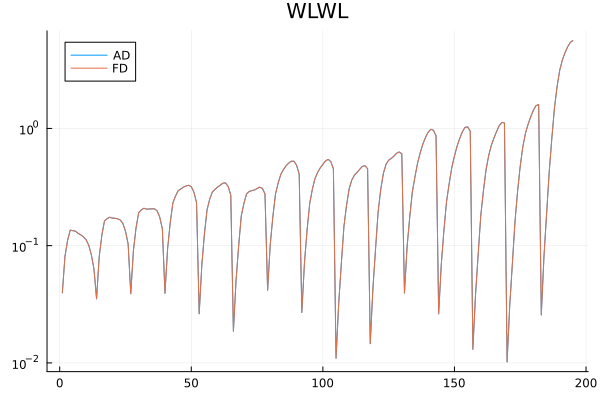

In [12]:
plot(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_AD)) ./ diag(meta_wlwl.cov), label="AD", title="WLWL")
plot!(abs.(diag(meta_wlwl.cov) .- diag(Cmod_wlwl_FD)) ./ diag(meta_wlwl.cov), yscale=:log10, label="FD", title="WLWL")

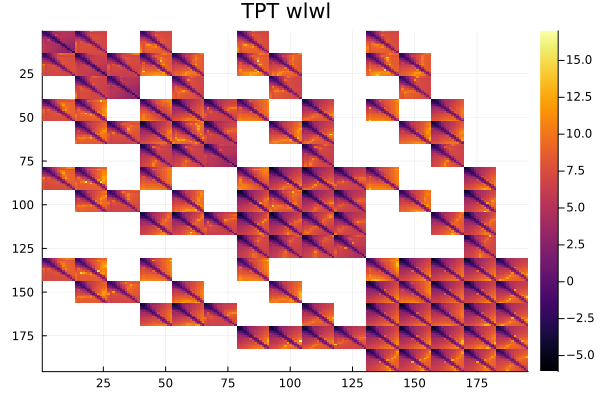

In [13]:
heatmap(log.(abs.((Cmod_wlwl_AD .- meta_wlwl.cov)./ meta_wlwl.cov)), title="TPT wlwl", yflip=true)

## GCGC

In [14]:
method = "bpz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc.yml"
nz_path = string("../data/CosmoDC2/image_nzs_", method, "_priors/")
gp_path = string("../data/CosmoDC2/image_gp_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

gp_lens_0 = npzread(string(gp_path, "gp_lens_0.npz"))
gp_lens_1 = npzread(string(gp_path, "gp_lens_1.npz"))
gp_lens_2 = npzread(string(gp_path, "gp_lens_2.npz"))
gp_lens_3 = npzread(string(gp_path, "gp_lens_3.npz"))
gp_lens_4 = npzread(string(gp_path, "gp_lens_4.npz"))

gp_zs_lens_0 = gp_lens_0["z"]
gp_zs_lens_1 = gp_lens_1["z"]
gp_zs_lens_2 = gp_lens_2["z"]
gp_zs_lens_3 = gp_lens_3["z"]
gp_zs_lens_4 = gp_lens_4["z"]

gp_mean_lens_0 = gp_lens_0["mean"]
gp_mean_lens_1 = gp_lens_1["mean"]
gp_mean_lens_2 = gp_lens_2["mean"]
gp_mean_lens_3 = gp_lens_3["mean"]
gp_mean_lens_4 = gp_lens_4["mean"]

gp_chol_lens_0 = gp_lens_0["chol"]
gp_chol_lens_1 = gp_lens_1["chol"]
gp_chol_lens_2 = gp_lens_2["chol"]
gp_chol_lens_3 = gp_lens_3["chol"]
gp_chol_lens_4 = gp_lens_4["chol"]

gp_W_lens_0 = gp_lens_0["W"]
gp_W_lens_1 = gp_lens_1["W"]
gp_W_lens_2 = gp_lens_2["W"]
gp_W_lens_3 = gp_lens_3["W"]
gp_W_lens_4 = gp_lens_4["W"]

gp_mean_lens = [
    gp_mean_lens_0; 
    gp_mean_lens_1;
    gp_mean_lens_2;
    gp_mean_lens_3;
    gp_mean_lens_4
    ]

meta_gcgc, files_gcgc = make_data(sacc_file, yaml_file;
                        nz_lens_0=nz_lens_0,
                        nz_lens_1=nz_lens_1,
                        nz_lens_2=nz_lens_2,
                        nz_lens_3=nz_lens_3,
                        nz_lens_4=nz_lens_4)

meta_gcgc.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density"]


lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
using custom nz for nz_lens_0
using custom nz for nz_lens_1
using custom nz for nz_lens_2
using custom nz for nz_lens_3
using custom nz for nz_lens_4


5-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"

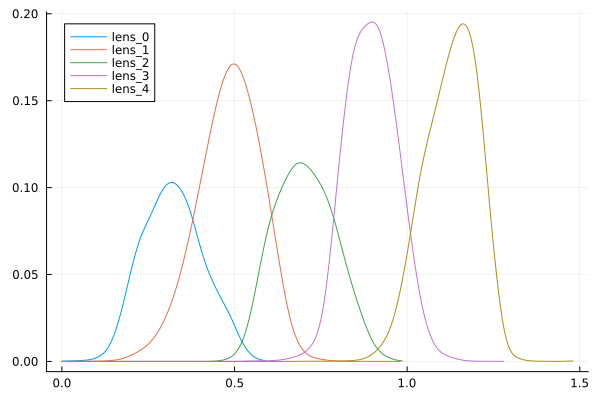

In [15]:
plot(files_gcgc["nz_lens_0"][1], files_gcgc["nz_lens_0"][2], label="lens_0")
plot!(files_gcgc["nz_lens_1"][1], files_gcgc["nz_lens_1"][2], label="lens_1")
plot!(files_gcgc["nz_lens_2"][1], files_gcgc["nz_lens_2"][2], label="lens_2")
plot!(files_gcgc["nz_lens_3"][1], files_gcgc["nz_lens_3"][2], label="lens_3")
plot!(files_gcgc["nz_lens_4"][1], files_gcgc["nz_lens_4"][2], label="lens_4")

In [16]:
function model_gcgc(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_gcgc, files=files_gcgc)

    alphas_lens_0 = alphas[1:10]
    alphas_lens_1 = alphas[11:20]
    alphas_lens_2 = alphas[21:30]
    alphas_lens_3 = alphas[31:40]
    alphas_lens_4 = alphas[41:50]

    nz_lens_0 = gp_W_lens_0 * gp_chol_lens_0 * alphas_lens_0
    nz_lens_0 += gp_mean_lens_0
    nz_lens_1 = gp_W_lens_1 * gp_chol_lens_1 * alphas_lens_1
    nz_lens_1 += gp_mean_lens_1
    nz_lens_2 = gp_W_lens_2 * gp_chol_lens_2 * alphas_lens_2
    nz_lens_2 += gp_mean_lens_2
    nz_lens_3 = gp_W_lens_3 * gp_chol_lens_3 * alphas_lens_3
    nz_lens_3 += gp_mean_lens_3
    nz_lens_4 = gp_W_lens_4 * gp_chol_lens_4 * alphas_lens_4
    nz_lens_4 += gp_mean_lens_4
    
    nuisances = Dict(
    "lens_1_b"    => lens_1_b,
    "lens_2_b"    => lens_2_b,
    "lens_3_b"    => lens_3_b,
    "lens_4_b"    => lens_4_b,
    "lens_5_b"    => lens_5_b,
    "lens_0_nz"   => nz_lens_0,
    "lens_1_nz"   => nz_lens_1,
    "lens_2_nz"   => nz_lens_2,
    "lens_3_nz"   => nz_lens_3,
    "lens_4_nz"   => nz_lens_4,
    "A_IA"        => A_IA)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [17]:
Cmod_gcgc_FD = make_Cmod(50, meta_gcgc.cov, model_gcgc; mode="FD")
Cmod_gcgc_AD = make_Cmod(50, meta_gcgc.cov, model_gcgc; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


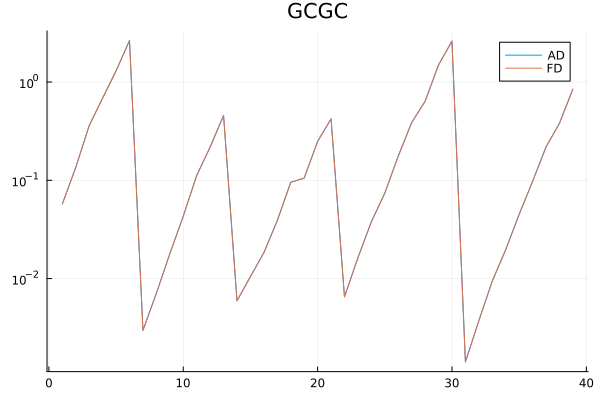

In [18]:
plot(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_AD)) ./ diag(meta_gcgc.cov), label="AD", title="GCGC")
plot!(abs.(diag(meta_gcgc.cov) .- diag(Cmod_gcgc_FD)) ./ diag(meta_gcgc.cov), yscale=:log10, label="FD")

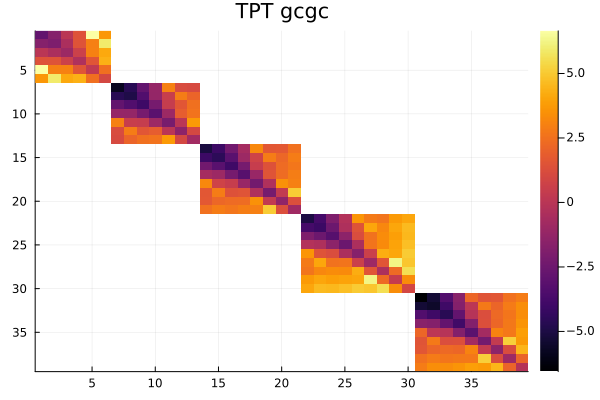

In [19]:
heatmap(log.(abs.((Cmod_gcgc_AD .- meta_gcgc.cov)./ meta_gcgc.cov)), title="TPT gcgc", yflip=true)

## 3x2

In [20]:
method = "bpz"
sacc_path = "../data/CosmoDC2/summary_statistics_fourier_tjpcov.sacc"
yaml_path = "../data/CosmoDC2/gcgc_gcwl_wlwl.yml"
nz_path = string("../data/CosmoDC2/image_nzs_", method, "_priors/")
gp_path = string("../data/CosmoDC2/image_gp_", method, "_priors/")

sacc_file = sacc.Sacc().load_fits(sacc_path)
yaml_file = YAML.load_file(yaml_path)

nz_lens_0 = npzread(string(nz_path, "nz_lens_0.npz"))
nz_lens_1 = npzread(string(nz_path, "nz_lens_1.npz"))
nz_lens_2 = npzread(string(nz_path, "nz_lens_2.npz"))
nz_lens_3 = npzread(string(nz_path, "nz_lens_3.npz"))
nz_lens_4 = npzread(string(nz_path, "nz_lens_4.npz"))
nz_source_0 = npzread(string(nz_path, "nz_source_0.npz"))
nz_source_1 = npzread(string(nz_path, "nz_source_1.npz"))
nz_source_2 = npzread(string(nz_path, "nz_source_2.npz"))
nz_source_3 = npzread(string(nz_path, "nz_source_3.npz"))
nz_source_4 = npzread(string(nz_path, "nz_source_4.npz"))

zs_k0, nz_k0 = nz_lens_0["z"], nz_lens_0["dndz"]
zs_k1, nz_k1 = nz_lens_1["z"], nz_lens_1["dndz"]
zs_k2, nz_k2 = nz_lens_2["z"], nz_lens_2["dndz"]
zs_k3, nz_k3 = nz_lens_3["z"], nz_lens_3["dndz"]
zs_k4, nz_k4 = nz_lens_4["z"], nz_lens_4["dndz"]
zs_k5, nz_k5 = nz_source_0["z"], nz_source_0["dndz"]
zs_k6, nz_k6 = nz_source_1["z"], nz_source_1["dndz"]
zs_k7, nz_k7 = nz_source_2["z"], nz_source_2["dndz"]
zs_k8, nz_k8 = nz_source_3["z"], nz_source_3["dndz"]
zs_k9, nz_k9 = nz_source_4["z"], nz_source_4["dndz"]

zs_k0, nz_k0 = LimberJack.nz_interpolate(zs_k0, nz_k0, 1000; mode="cubic")
zs_k1, nz_k1 = LimberJack.nz_interpolate(zs_k1, nz_k1, 1000; mode="cubic")
zs_k2, nz_k2 = LimberJack.nz_interpolate(zs_k2, nz_k2, 1000; mode="cubic")
zs_k3, nz_k3 = LimberJack.nz_interpolate(zs_k3, nz_k3, 1000; mode="cubic")
zs_k4, nz_k4 = LimberJack.nz_interpolate(zs_k4, nz_k4, 1000; mode="cubic")
zs_k5, nz_k5 = LimberJack.nz_interpolate(zs_k5, nz_k5, 1000; mode="cubic")
zs_k6, nz_k6 = LimberJack.nz_interpolate(zs_k6, nz_k6, 1000; mode="cubic")
zs_k7, nz_k7 = LimberJack.nz_interpolate(zs_k7, nz_k7, 1000; mode="cubic")
zs_k8, nz_k8 = LimberJack.nz_interpolate(zs_k8, nz_k8, 1000; mode="cubic")
zs_k9, nz_k9 = LimberJack.nz_interpolate(zs_k9, nz_k9, 1000; mode="cubic")

nz_lens_0 = Dict("z"=>zs_k0, "dndz"=>nz_k0)
nz_lens_1 = Dict("z"=>zs_k1, "dndz"=>nz_k1)
nz_lens_2 = Dict("z"=>zs_k2, "dndz"=>nz_k2)
nz_lens_3 = Dict("z"=>zs_k3, "dndz"=>nz_k3)
nz_lens_4 = Dict("z"=>zs_k4, "dndz"=>nz_k4)
nz_source_0 = Dict("z"=>zs_k5, "dndz"=>nz_k5)
nz_source_1 = Dict("z"=>zs_k6, "dndz"=>nz_k6)
nz_source_2 = Dict("z"=>zs_k7, "dndz"=>nz_k7)
nz_source_3 = Dict("z"=>zs_k8, "dndz"=>nz_k8)
nz_source_4 = Dict("z"=>zs_k9, "dndz"=>nz_k9)

mu_k0 = sum(zs_k0 .* nz_k0) / sum(nz_k0)
mu_k1 = sum(zs_k1 .* nz_k1) / sum(nz_k1)
mu_k2 = sum(zs_k2 .* nz_k2) / sum(nz_k2)
mu_k3 = sum(zs_k3 .* nz_k3) / sum(nz_k3)
mu_k4 = sum(zs_k4 .* nz_k4) / sum(nz_k4)
mu_k5 = sum(zs_k5 .* nz_k5) / sum(nz_k5)
mu_k6 = sum(zs_k6 .* nz_k6) / sum(nz_k6)
mu_k7 = sum(zs_k7 .* nz_k7) / sum(nz_k7)
mu_k8 = sum(zs_k8 .* nz_k8) / sum(nz_k8)
mu_k9 = sum(zs_k9 .* nz_k9) / sum(nz_k9)

gp_source_0 = npzread(string(gp_path, "gp_source_0.npz"))
gp_source_1 = npzread(string(gp_path, "gp_source_1.npz"))
gp_source_2 = npzread(string(gp_path, "gp_source_2.npz"))
gp_source_3 = npzread(string(gp_path, "gp_source_3.npz"))
gp_source_4 = npzread(string(gp_path, "gp_source_4.npz"))
gp_lens_0 = npzread(string(gp_path, "gp_lens_0.npz"))
gp_lens_1 = npzread(string(gp_path, "gp_lens_1.npz"))
gp_lens_2 = npzread(string(gp_path, "gp_lens_2.npz"))
gp_lens_3 = npzread(string(gp_path, "gp_lens_3.npz"))
gp_lens_4 = npzread(string(gp_path, "gp_lens_4.npz"))

gp_zs_source_0 = gp_source_0["z"]
gp_zs_source_1 = gp_source_1["z"]
gp_zs_source_2 = gp_source_2["z"]
gp_zs_source_3 = gp_source_3["z"]
gp_zs_source_4 = gp_source_4["z"]
gp_zs_lens_0 = gp_lens_0["z"]
gp_zs_lens_1 = gp_lens_1["z"]
gp_zs_lens_2 = gp_lens_2["z"]
gp_zs_lens_3 = gp_lens_3["z"]
gp_zs_lens_4 = gp_lens_4["z"]

gp_mean_source_0 = gp_source_0["mean"]
gp_mean_source_1 = gp_source_1["mean"]
gp_mean_source_2 = gp_source_2["mean"]
gp_mean_source_3 = gp_source_3["mean"]
gp_mean_source_4 = gp_source_4["mean"]
gp_mean_lens_0 = gp_lens_0["mean"]
gp_mean_lens_1 = gp_lens_1["mean"]
gp_mean_lens_2 = gp_lens_2["mean"]
gp_mean_lens_3 = gp_lens_3["mean"]
gp_mean_lens_4 = gp_lens_4["mean"]

gp_chol_source_0 = gp_source_0["chol"]
gp_chol_source_1 = gp_source_1["chol"]
gp_chol_source_2 = gp_source_2["chol"]
gp_chol_source_3 = gp_source_3["chol"]
gp_chol_source_4 = gp_source_4["chol"]
gp_chol_lens_0 = gp_lens_0["chol"]
gp_chol_lens_1 = gp_lens_1["chol"]
gp_chol_lens_2 = gp_lens_2["chol"]
gp_chol_lens_3 = gp_lens_3["chol"]
gp_chol_lens_4 = gp_lens_4["chol"]

gp_W_source_0 = gp_source_0["W"]
gp_W_source_1 = gp_source_1["W"]
gp_W_source_2 = gp_source_2["W"]
gp_W_source_3 = gp_source_3["W"]
gp_W_source_4 = gp_source_4["W"]
gp_W_lens_0 = gp_lens_0["W"]
gp_W_lens_1 = gp_lens_1["W"]
gp_W_lens_2 = gp_lens_2["W"]
gp_W_lens_3 = gp_lens_3["W"]
gp_W_lens_4 = gp_lens_4["W"]

gp_mean_3x2 = [
    gp_mean_source_0;
    gp_mean_source_1;
    gp_mean_source_2;
    gp_mean_source_3;
    gp_mean_source_4;
    gp_mean_lens_0; 
    gp_mean_lens_1;
    gp_mean_lens_2;
    gp_mean_lens_3;
    gp_mean_lens_4
    ]

meta_3x2, files_3x2 = make_data(sacc_file, yaml_file;
    nz_lens_0=nz_lens_0,
    nz_lens_1=nz_lens_1,
    nz_lens_2=nz_lens_2,
    nz_lens_3=nz_lens_3,
    nz_lens_4=nz_lens_4,
    nz_source_0=nz_source_0,
    nz_source_1=nz_source_1,
    nz_source_2=nz_source_2,
    nz_source_3=nz_source_3,
    nz_source_4=nz_source_4)


meta_3x2.types = [ 
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_density",
    "galaxy_shear", 
    "galaxy_shear", 
    "galaxy_shear",
    "galaxy_shear",
    "galaxy_shear"]

lens_0 lens_0 6
lens_1 lens_1 7
lens_2 lens_2 8
lens_3 lens_3 9
lens_4 lens_4 9
source_0 lens_0 6
source_0 lens_1 7
source_0 lens_2 8
source_0 lens_3 9
source_0 lens_4 9
source_1 lens_0 8
source_1 lens_1 7
source_1 lens_2 8
source_1 lens_3 9
source_1 lens_4 9
source_2 lens_0 8
source_2 lens_1 7
source_2 lens_2 8
source_2 lens_3 9
source_2 lens_4 9
source_3 lens_0 8
source_3 lens_1 7
source_3 lens_2 8
source_3 lens_3 9
source_3 lens_4 9
source_4 lens_0 8
source_4 lens_1 7
source_4 lens_2 8
source_4 lens_3 9
source_4 lens_4 9
source_0 source_0 13
source_1 source_0 13
source_1 source_1 13
source_2 source_0 13
source_2 source_1 13
source_2 source_2 13
source_3 source_0 13
source_3 source_1 13
source_3 source_2 13
source_3 source_3 13
source_4 source_0 13
source_4 source_1 13
source_4 source_2 13
source_4 source_3 13
source_4 source_4 13
using custom nz for nz_source_0
using custom nz for nz_source_1
using custom nz for nz_source_2
using custom nz for nz_source_3
using custom nz for nz_sour

10-element Vector{String}:
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_density"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"
 "galaxy_shear"

In [21]:
function model_3x2(alphas; 
    Ωm=0.27347, σ8=0.779007, Ωb=0.04217, h=0.71899, ns=0.99651,
    lens_1_b=0.879118, lens_2_b=1.05894, lens_3_b=1.22145, lens_4_b=1.35065, lens_5_b=1.58909,
    A_IA=0.25179439,
    meta=meta_3x2, files=files_3x2)

    alphas_source_0 = alphas[1:10]
    alphas_source_1 = alphas[11:20]
    alphas_source_2 = alphas[21:30]
    alphas_source_3 = alphas[31:40]
    alphas_source_4 = alphas[41:50]
    alphas_lens_0 = alphas[51:60]
    alphas_lens_1 = alphas[61:70]
    alphas_lens_2 = alphas[71:80]
    alphas_lens_3 = alphas[81:90]
    alphas_lens_4 = alphas[91:100]

    nz_source_0 = gp_W_source_0 * gp_chol_source_0 * alphas_source_0
    nz_source_0 += gp_mean_source_0
    nz_source_1 = gp_W_source_1 * gp_chol_source_1 * alphas_source_1
    nz_source_1 += gp_mean_source_1
    nz_source_2 = gp_W_source_2 * gp_chol_source_2 * alphas_source_2
    nz_source_2 += gp_mean_source_2
    nz_source_3 = gp_W_source_3 * gp_chol_source_3 * alphas_source_3
    nz_source_3 += gp_mean_source_3
    nz_source_4 = gp_W_source_4 * gp_chol_source_4 * alphas_source_4
    nz_source_4 += gp_mean_source_4
    nz_lens_0 = gp_W_lens_0 * gp_chol_lens_0 * alphas_lens_0
    nz_lens_0 += gp_mean_lens_0
    nz_lens_1 = gp_W_lens_1 * gp_chol_lens_1 * alphas_lens_1
    nz_lens_1 += gp_mean_lens_1
    nz_lens_2 = gp_W_lens_2 * gp_chol_lens_2 * alphas_lens_2
    nz_lens_2 += gp_mean_lens_2
    nz_lens_3 = gp_W_lens_3 * gp_chol_lens_3 * alphas_lens_3
    nz_lens_3 += gp_mean_lens_3
    nz_lens_4 = gp_W_lens_4 * gp_chol_lens_4 * alphas_lens_4
    nz_lens_4 += gp_mean_lens_4

    nuisances = Dict(
        "lens_1_b"    => lens_1_b,
        "lens_2_b"    => lens_2_b,
        "lens_3_b"    => lens_3_b,
        "lens_4_b"    => lens_4_b,
        "lens_5_b"    => lens_5_b,
        "lens_0_nz"   => nz_lens_0,
        "lens_1_nz"   => nz_lens_1,
        "lens_2_nz"   => nz_lens_2,
        "lens_3_nz"   => nz_lens_3,
        "lens_4_nz"   => nz_lens_4,
        "source_0_nz" => nz_source_0,
        "source_1_nz" => nz_source_1,
        "source_2_nz" => nz_source_2,
        "source_3_nz" => nz_source_3,
        "source_4_nz" => nz_source_4,
        "A_IA"        => A_IA)
        
    cosmo = Cosmology(Ωm=Ωm, Ωb=Ωb, h=h, ns=ns, σ8=σ8,
        tk_mode=:EisHu,
        pk_mode=:Halofit)

    cosmo.settings.cosmo_type = eltype(valtype(alphas))
    return Theory(cosmo, meta, files; Nuisances=nuisances)
end;

In [22]:
Cmod_3x2_FD = make_Cmod(100, meta_3x2.cov, model_3x2; mode="FD");
Cmod_3x2_AD = make_Cmod(100, meta_3x2.cov, model_3x2; mode="AD");

Using finite differences to compute T
Using automatic differentiation to compute T


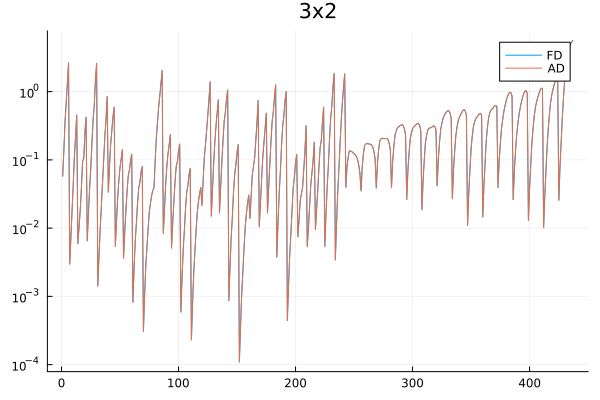

In [23]:
plot(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_FD)) ./ diag(meta_3x2.cov), label="FD", title="3x2")
plot!(abs.(diag(meta_3x2.cov) .- diag(Cmod_3x2_AD)) ./ diag(meta_3x2.cov), yscale=:log10, label="AD")

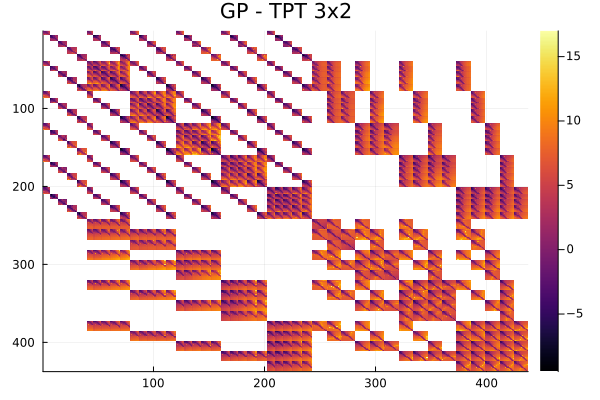

In [24]:
heatmap(log.(abs.((Cmod_3x2_AD .- meta_3x2.cov)./ meta_3x2.cov)), title="GP - TPT 3x2", yflip=true)

## Save

In [25]:
using NPZ
npzwrite("../covs/COSMODC2/gp_covs.npz",
        Dict(
        "wlwl_AD" => Cmod_wlwl_AD,
        "wlwl_FD" => Cmod_wlwl_FD,
        "gcgc_AD" => Cmod_gcgc_AD,
        "gcgc_FD" => Cmod_gcgc_FD,
        "3x2_AD" => Cmod_3x2_AD,
        "3x2_FD" => Cmod_3x2_FD))